# Credit Card Fraud Detection using Autoencoders
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [100]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [101]:
# Load the data
df = pd.read_csv("data/creditcard.csv")

# Exploratory Analysis

Let us start to give a look at the data to extract useful information and understand the available informations.

In [102]:
# Print the number of rows and features of the dataset
df.shape

(284807, 31)

We have 31 columns: Time, V1, V2, ..., V28, Amount and Class. Let's check for missing values:

In [103]:
# Check if some value is null
df.isnull().values.any()

False

What about the distrubutions?

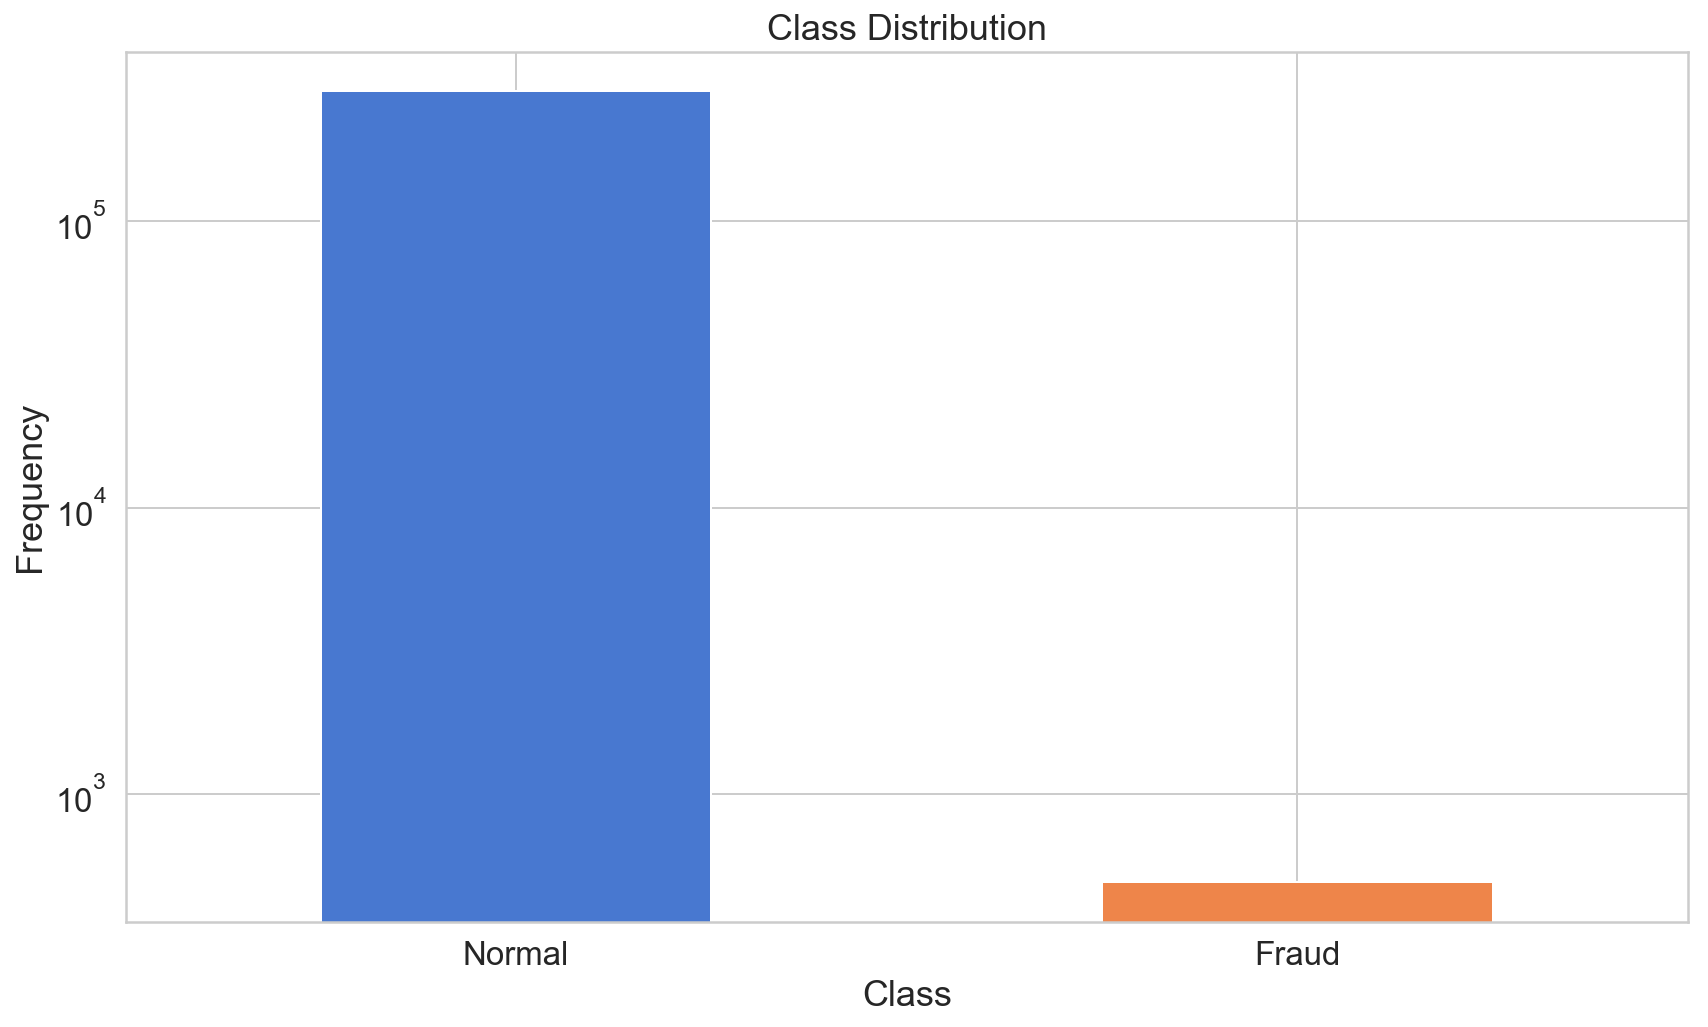

In [104]:
# Plot the distribution of each class in a log scale
number_of_classes = pd.value_counts(df['Class'], sort = True)
number_of_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(len(number_of_classes)), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
plt.yscale('log')

In [105]:
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
print("Normal: {}, Frauds: {}".format(normal.shape[0], fraud.shape[0]))

Normal: 284315, Frauds: 492


We have a highly unbalanced dataset. Thus we need to perform some form of data augmentation! Let us look at the distribution of the Amout per transaction of the two classes.

In [106]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [107]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

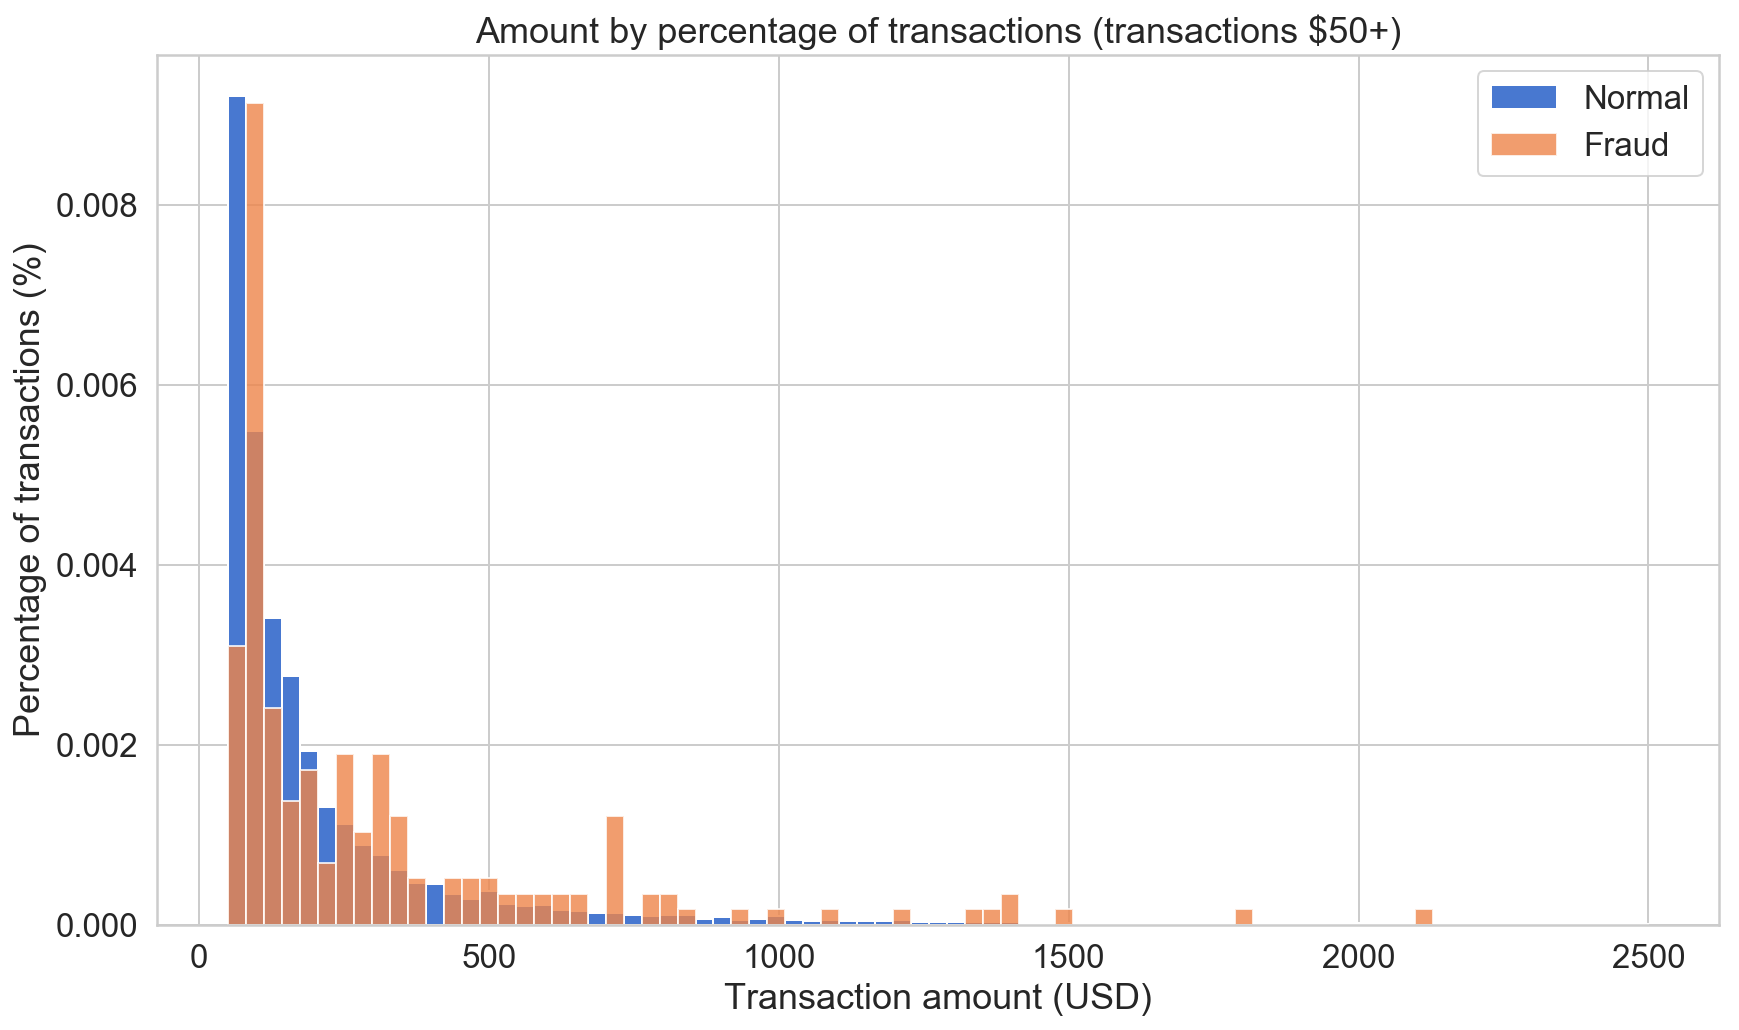

In [108]:
# Plot the percentage of transactions for each value >= tha $50
bins = np.linspace(50, 2500, 80)
plt.hist(normal['Amount'], bins, alpha=1, density=True, label='Normal')
plt.hist(fraud['Amount'], bins, alpha=0.8, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$50+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

We can also analyse the correlation between Time and Amount of each transaction for each class.

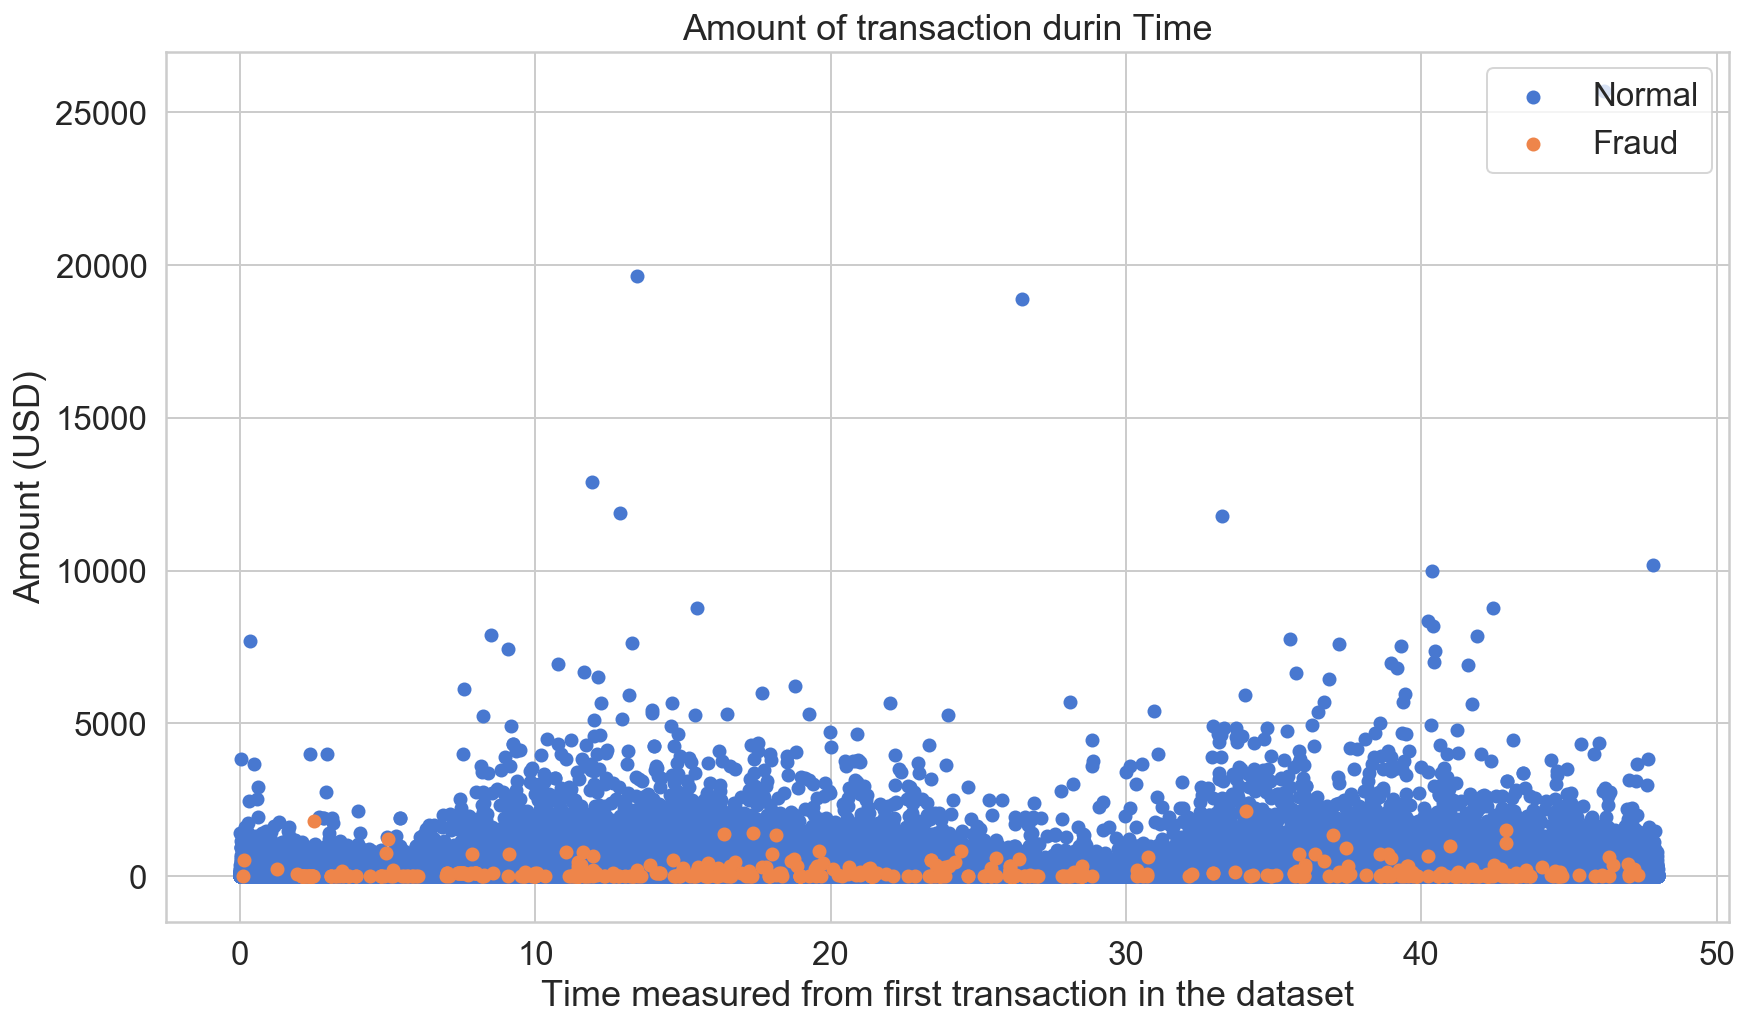

In [109]:
# Plot the the amount of transactions w.r.t. time 
plt.scatter((normal['Time']/(3600)), normal['Amount'], alpha=1, label='Normal')
plt.scatter((fraud['Time']/(3600)), fraud['Amount'], alpha=1, label='Fraud')
plt.title("Amount of transaction durin Time")
plt.xlabel("Time measured from first transaction in the dataset")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

Notice that Time represent the amount of time elapsed from the first transaction. It seems that time of transaction does not matter and it is not as representative of the data. Hence it is better to drop this feature from the dataset. Let’s drop the Time column and use the scikit’s StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [110]:
# We plot the shape of the 'cleaned' dataset
data = df.drop(['Time'], axis=1) 
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.shape

(284807, 30)

We plot the density distribution of each feature w.r.t. the class.

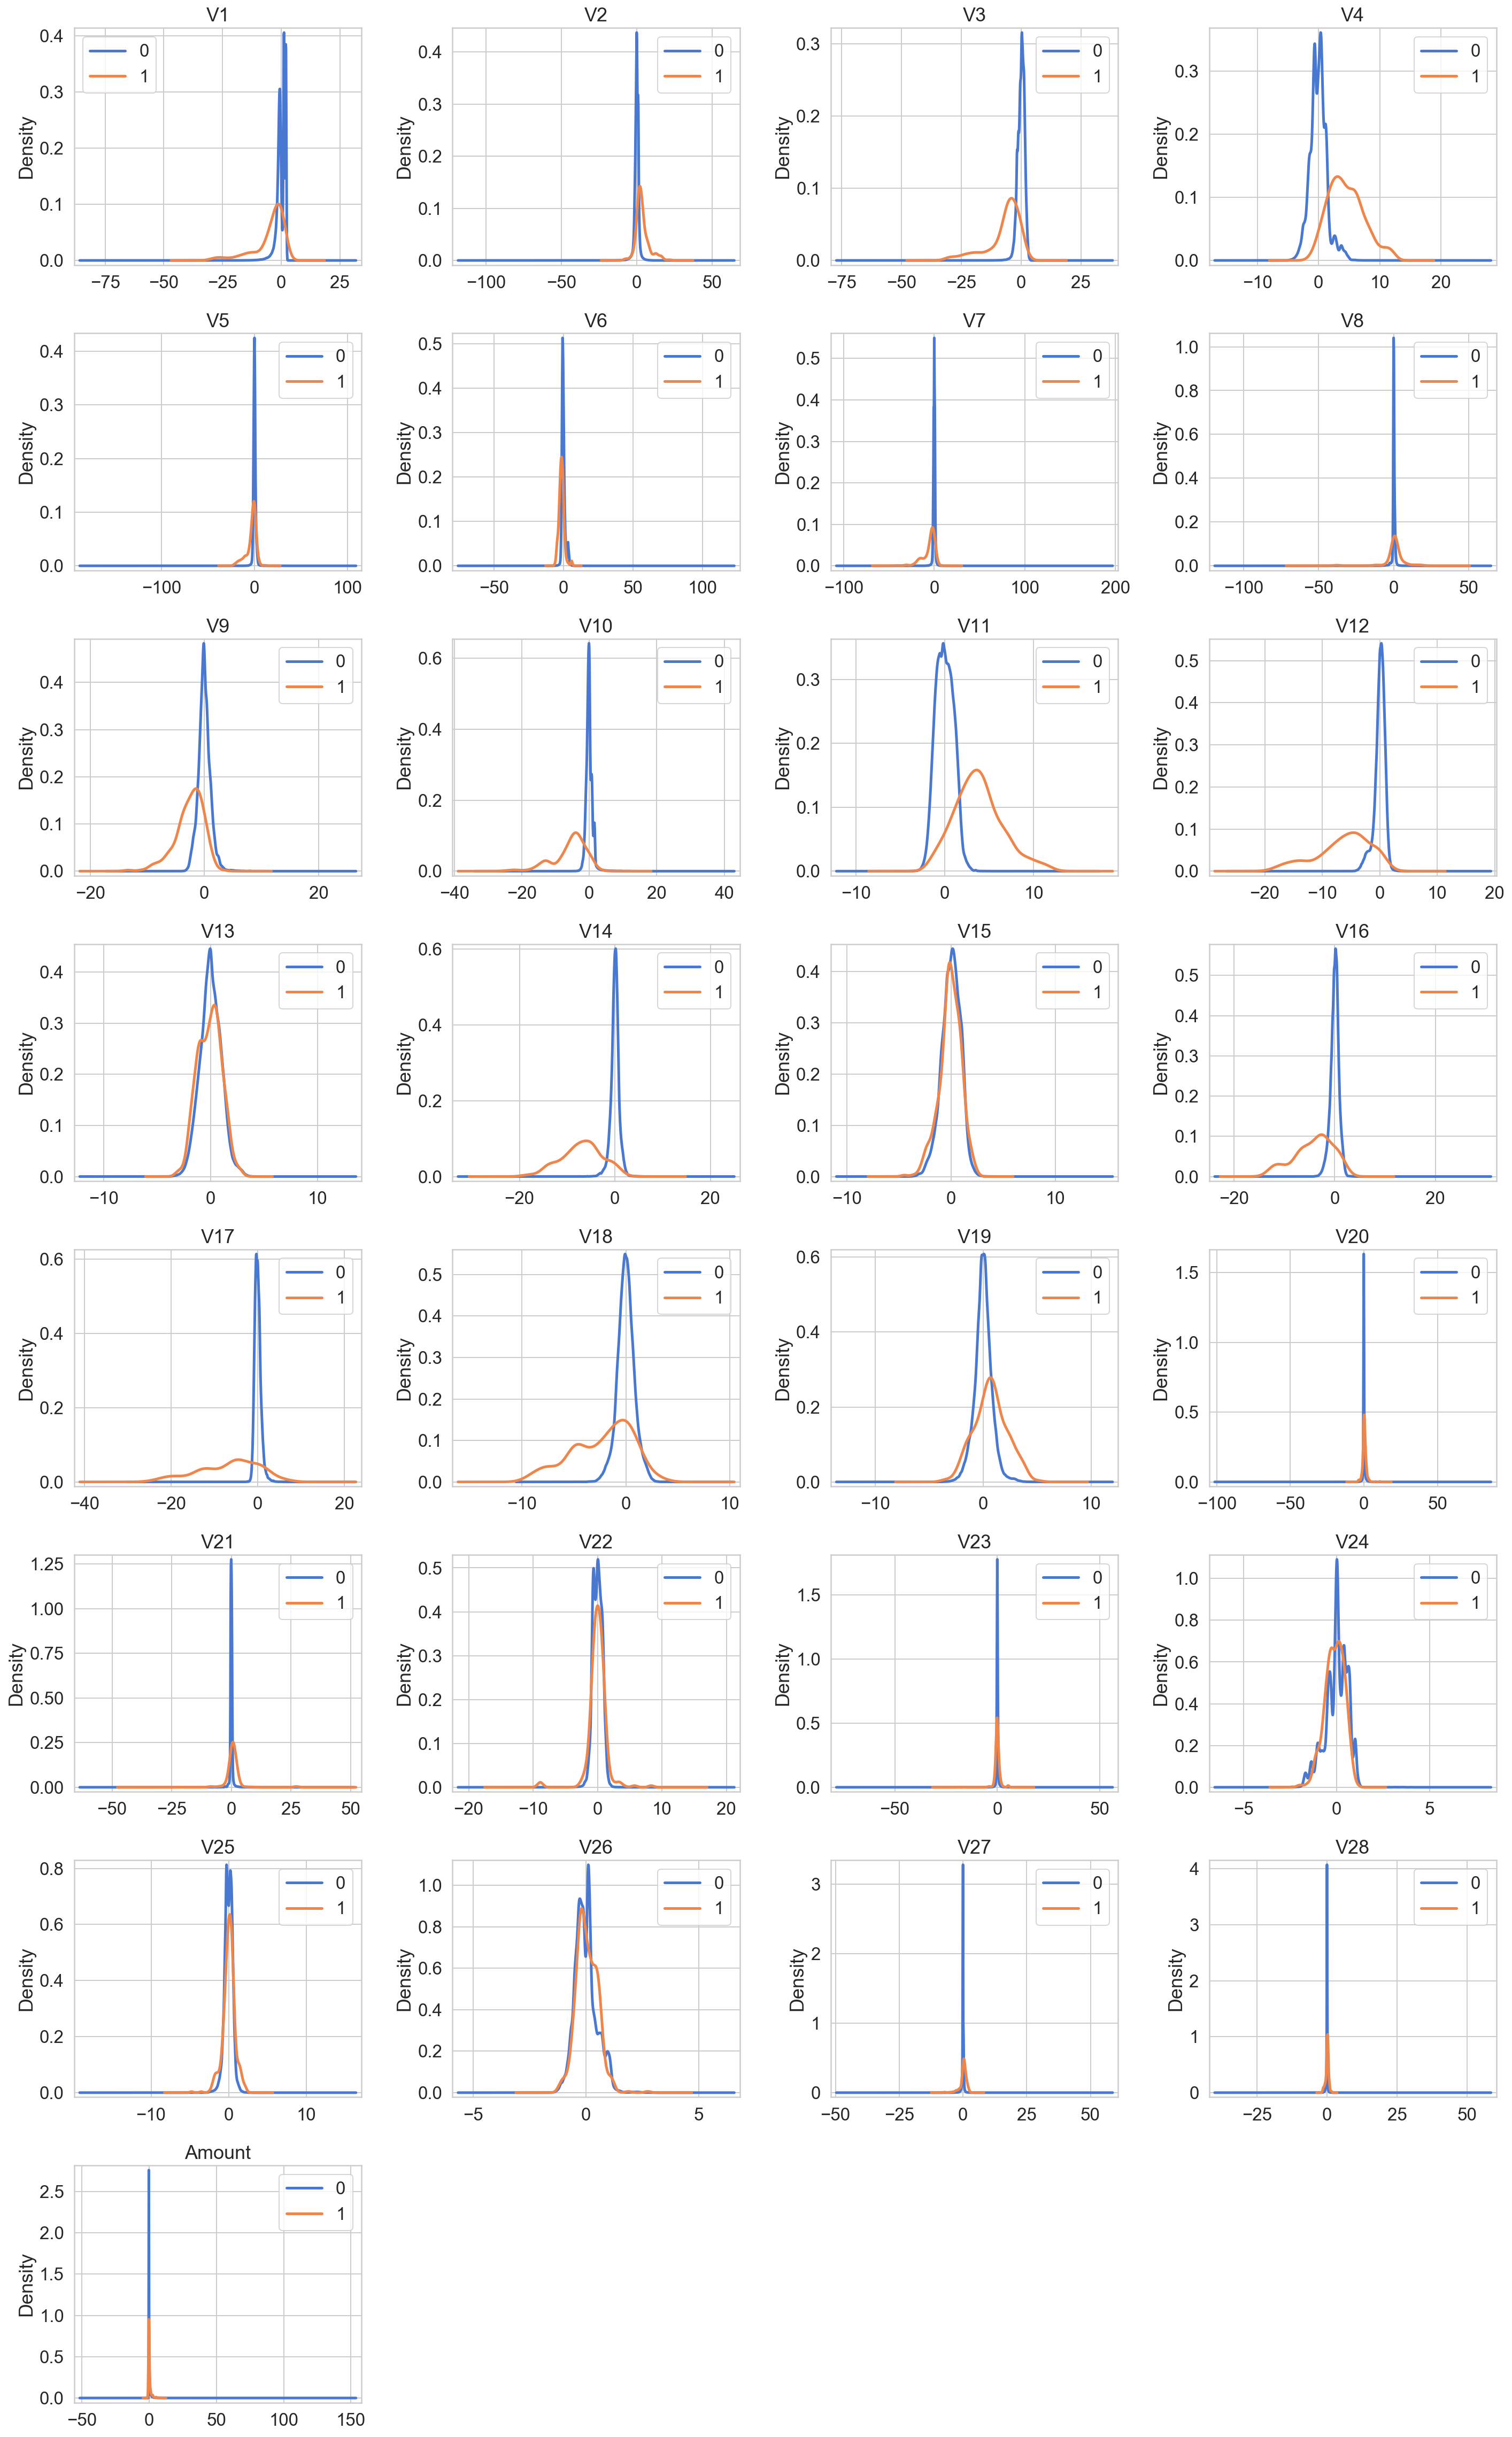

In [111]:
# Scatter subplots
plt.figure(figsize=(20,32))
for plot, feat in enumerate(data.columns[:-1]):
    plt.subplot(8, 4, (plot+1))
    title = str(feat)
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([data[feat], data['Class']], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=1, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

From the plot above, we can select the most important and relevant features. 

In [112]:
data = data.drop(['V13', 'V15', 'V22', 'V23', 'V26', 'Amount'], axis=1) 
data.shape

(284807, 24)

# Autoencoder
Now we split the data into training and testing sets. We will reserve 20% of our data for testing.

In [113]:
# Split the dataset in training and testint sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 23)

In [114]:
# We use a subset of training for validation
X_train, X_val = train_test_split(X_train, test_size = 0.1, random_state=RANDOM_SEED)
X_train.shape

(204705, 23)

The Autoencoder that we are going to develop has 4 layes. The first two layers encode the data with 14 and 7 neurons respectively, while the other two start to reconstruct the input:

In [115]:
input_dim = X_train.shape[1]
encoding_dim = 28
learning_rate = 0.001

# Build the autoencoder with 6 layers. During the encoding phase we map the input into a larger space,
# than with deconding we try to reconstruct the original vector
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(int(encoding_dim * 2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim * 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)
model = Model(inputs=input_layer, outputs=decoder)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 23)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 28)                672       
_________________________________________________________________
dense_56 (Dense)             (None, 56)                1624      
_________________________________________________________________
dense_57 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_58 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_59 (Dense)             (None, 23)                667       
Total params: 7,751
Trainable params: 7,751
Non-trainable params: 0
_________________________________________________________________


In [116]:
nb_epoch = 100
batch_size = 128
model.compile(optimizer='adam',  loss='mean_squared_error',  metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

# Train the autoencoder
tensorboard = TensorBoard(histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_data=(X_val, X_val), verbose=1, callbacks=[checkpointer, tensorboard]).history

Train on 204705 samples, validate on 22746 samples
Epoch 1/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.9116 - acc: 0.6966 - val_loss: 0.8098 - val_acc: 0.8010
Epoch 2/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.7360 - acc: 0.8138 - val_loss: 0.7752 - val_acc: 0.8393
Epoch 3/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.7186 - acc: 0.8329 - val_loss: 0.7647 - val_acc: 0.8385
Epoch 4/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.7109 - acc: 0.8434 - val_loss: 0.7548 - val_acc: 0.8441
Epoch 5/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.7066 - acc: 0.8450 - val_loss: 0.7505 - val_acc: 0.8543
Epoch 6/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.7039 - acc: 0.8486 - val_loss: 0.7513 - val_acc: 0.8473
Epoch 7/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.6979 - acc: 0.8550 - val_

Epoch 59/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6831 - acc: 0.8855 - val_loss: 0.7221 - val_acc: 0.8875
Epoch 60/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.6787 - acc: 0.8890 - val_loss: 0.7408 - val_acc: 0.8728
Epoch 61/100
204705/204705 [==============================] - 3s 12us/step - loss: 0.6785 - acc: 0.8919 - val_loss: 0.7168 - val_acc: 0.8928
Epoch 62/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6763 - acc: 0.8953 - val_loss: 0.7151 - val_acc: 0.8968
Epoch 63/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6820 - acc: 0.8846 - val_loss: 0.7156 - val_acc: 0.9113
Epoch 64/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6780 - acc: 0.8936 - val_loss: 0.7164 - val_acc: 0.9073
Epoch 65/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6771 - acc: 0.8942 - val_loss: 0.7130 - val_acc: 0.9120
Epoch 66/100


# Evaluation
Let us start to evaluate the performances. First of all, we plot the loss function to check if the model has learned something.

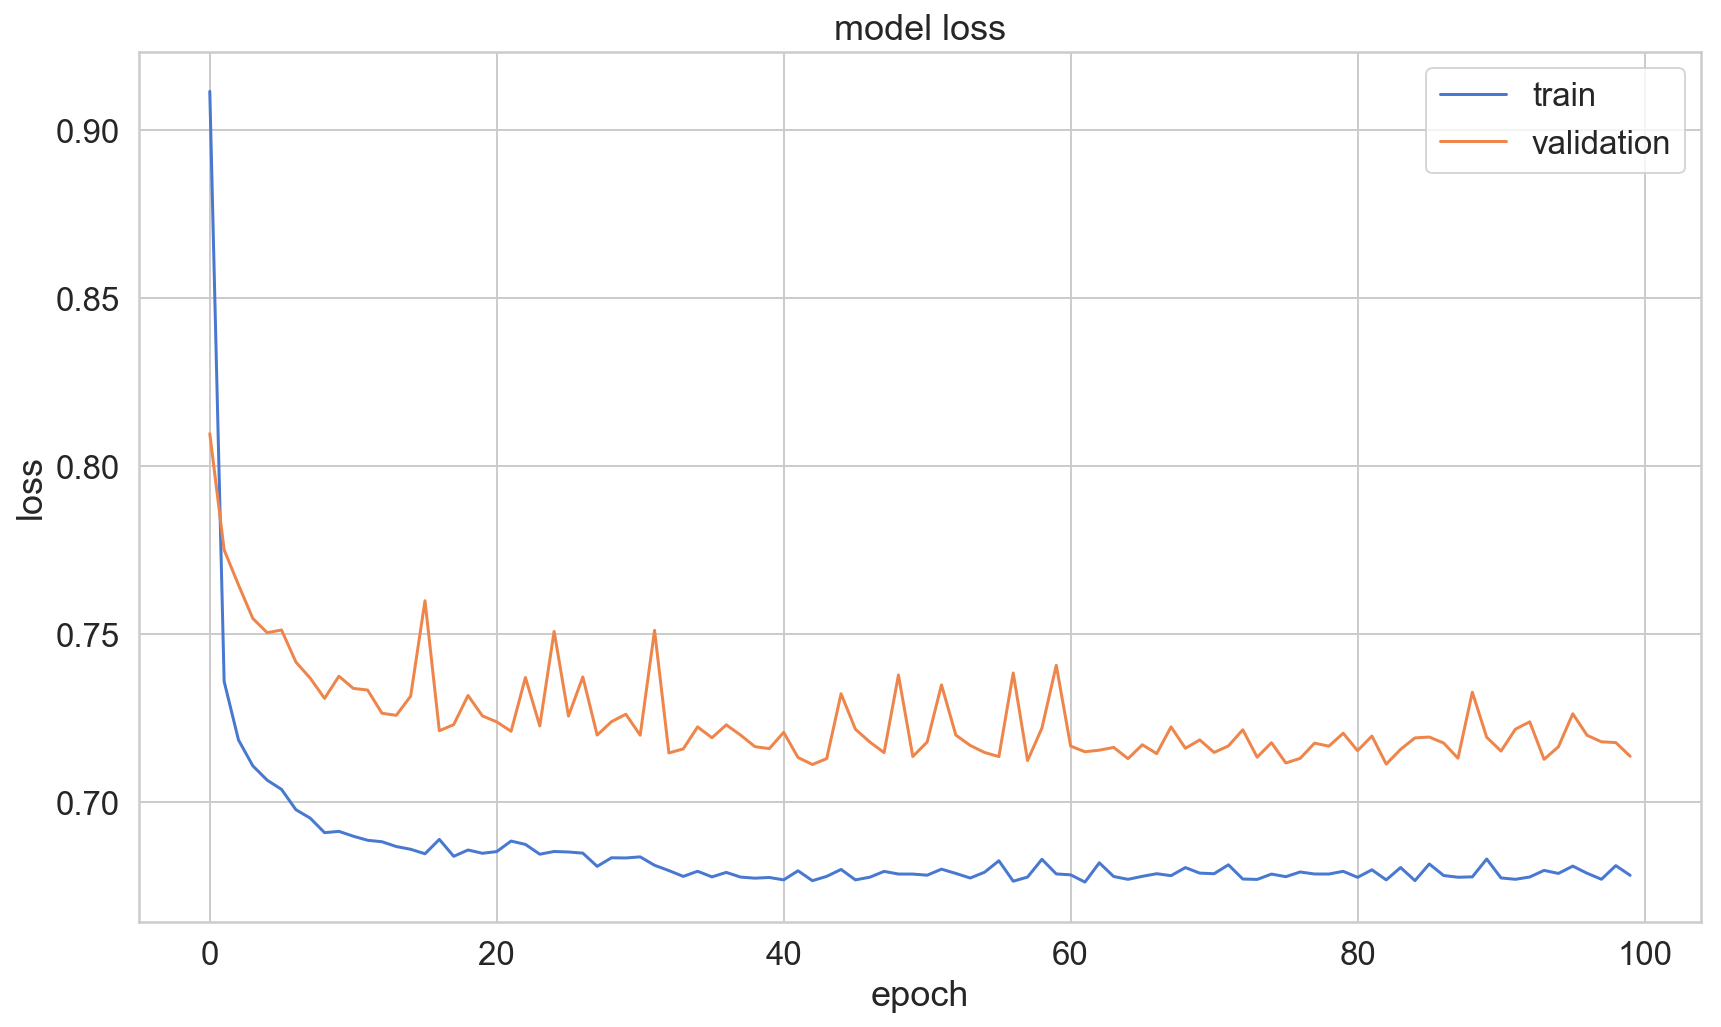

In [117]:
# Plot the loss function
plt.figure(figsize=(14,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right');

The reconstruction error on our training and test data seems to converge. Let’s analyse the error distribution:

In [118]:
# We predict new (and unseen) data to evaluate the model
predictions = model.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.705730,0.001720
std,4.010903,0.041443
min,0.011410,0.000000
25%,0.172751,0.000000
50%,0.309351,0.000000
75%,0.553746,0.000000
max,337.264938,1.000000


We can use ROC curves to measure the performaces of the neural network:

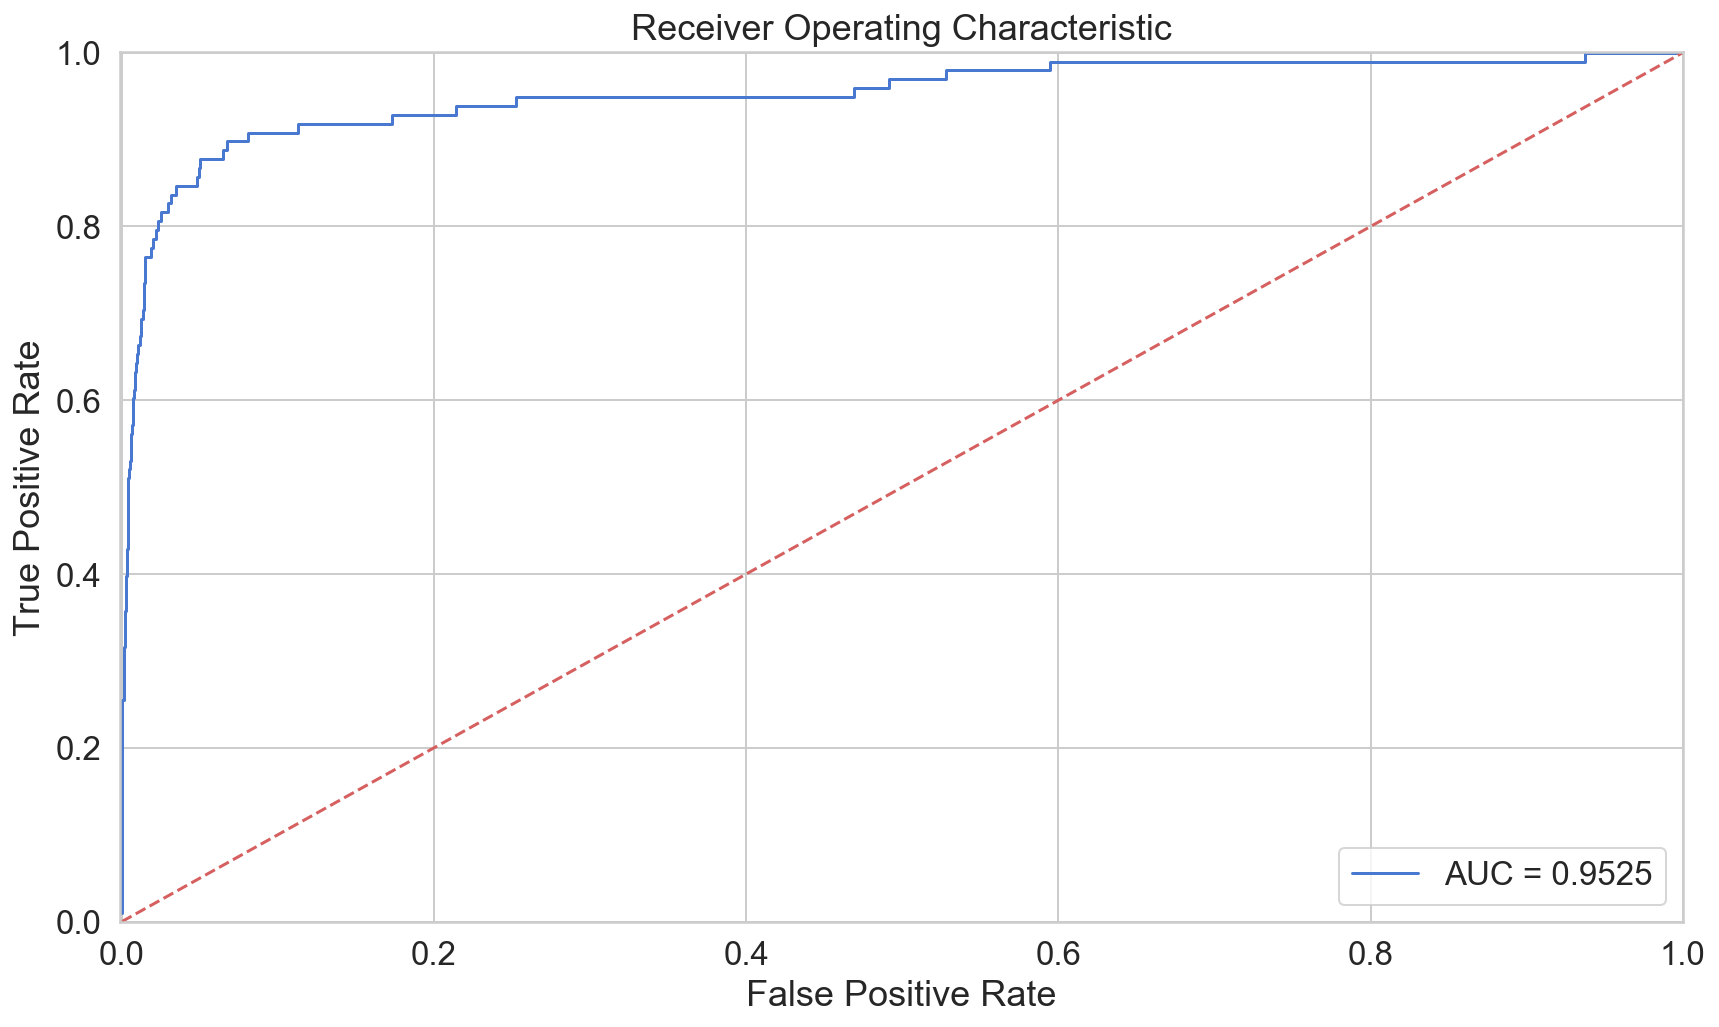

In [119]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Remember that recall measure the relevant items that have been selected. Precision measures how many selected items are relevant. We would like to obtain high values of both.

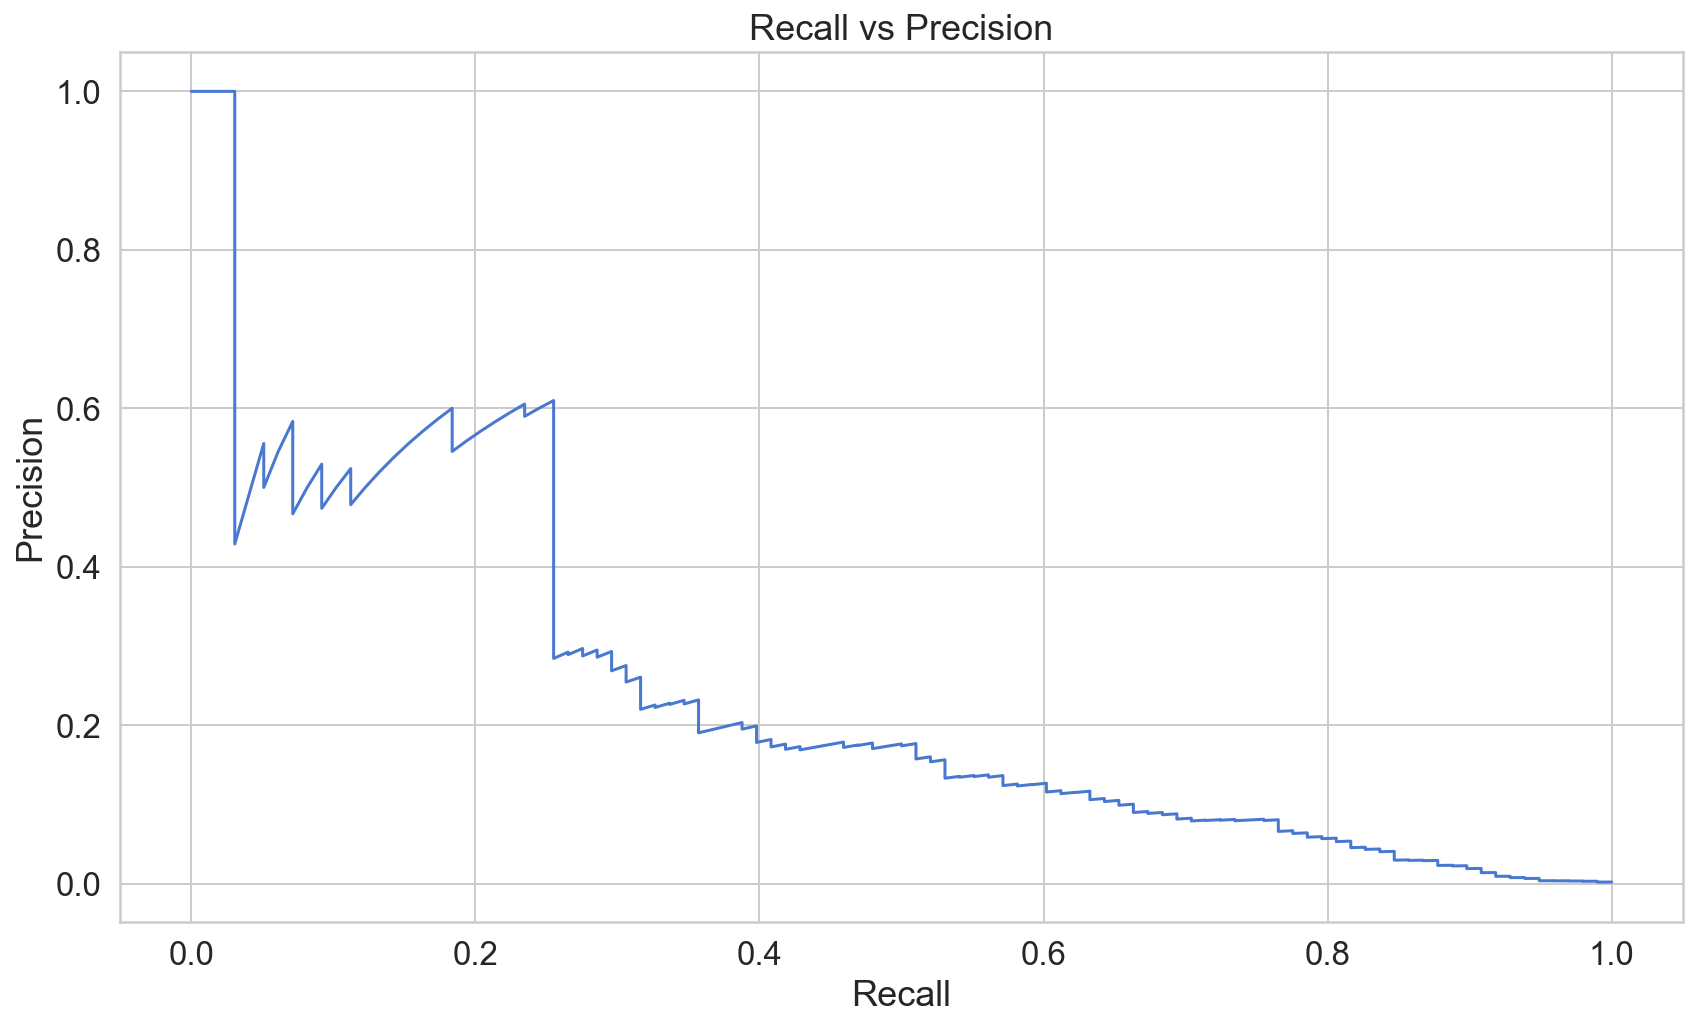

In [120]:
# Plot precision-recall curve
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

High precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results with the majority of correct results.

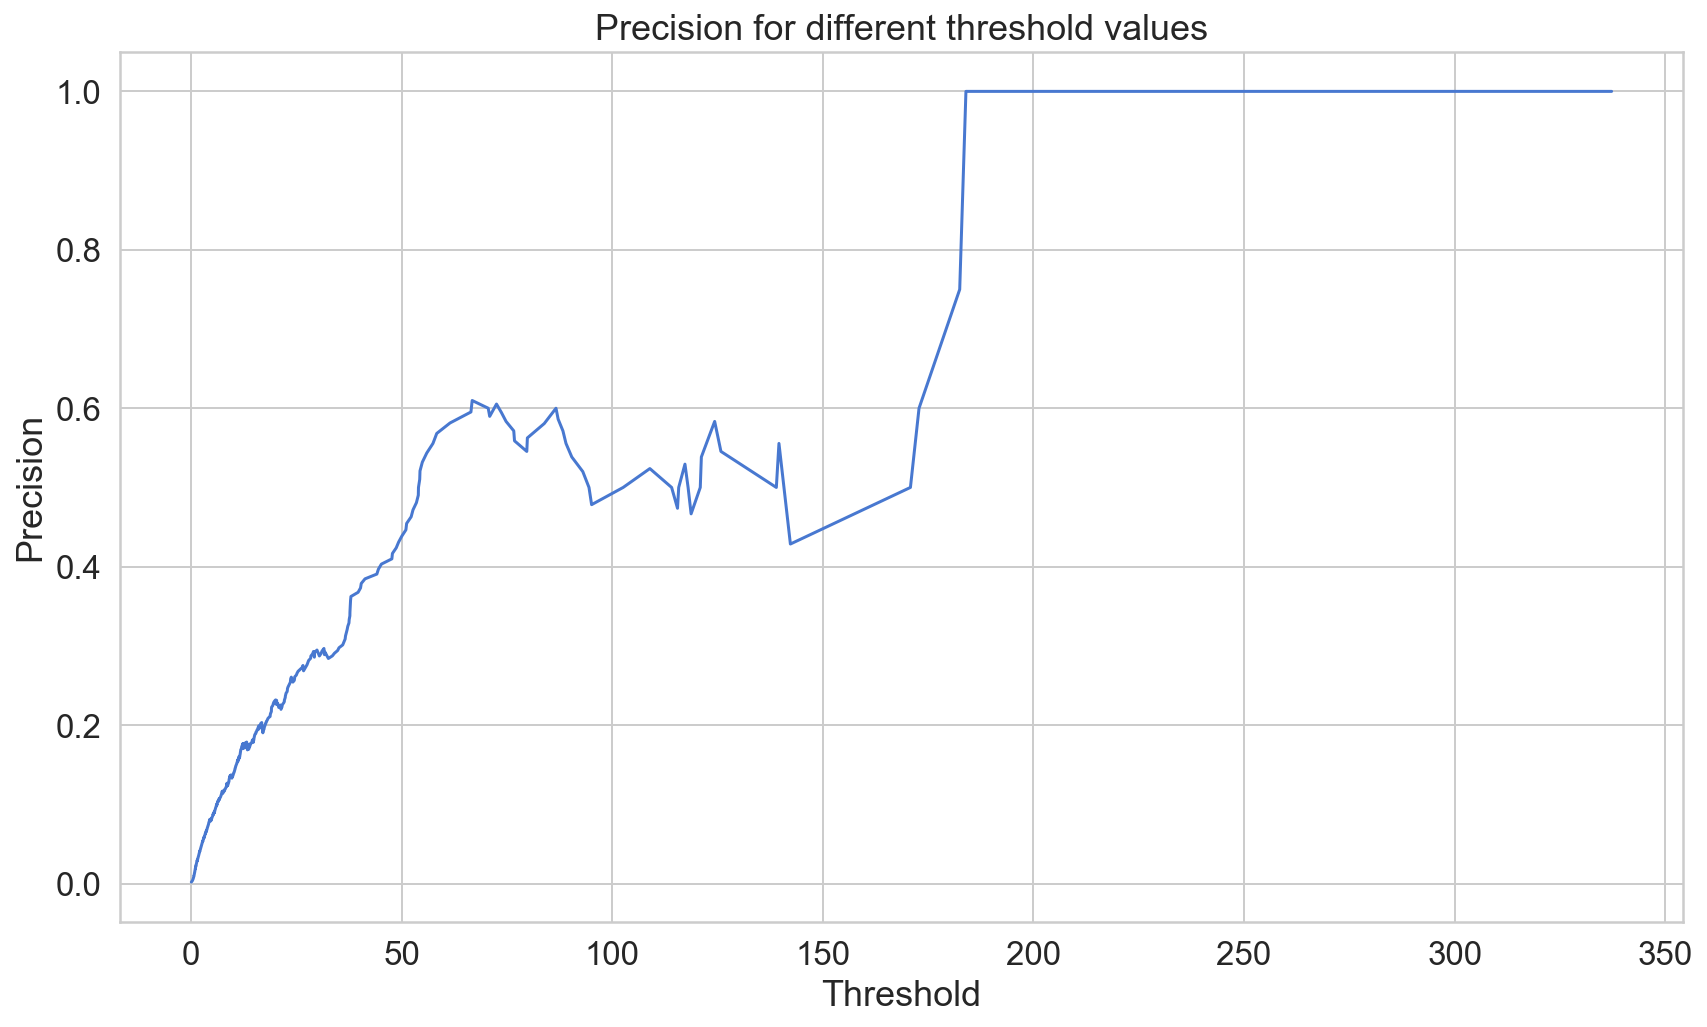

In [121]:
# Plot precision for different thresholds
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let’s have a look at the recall:



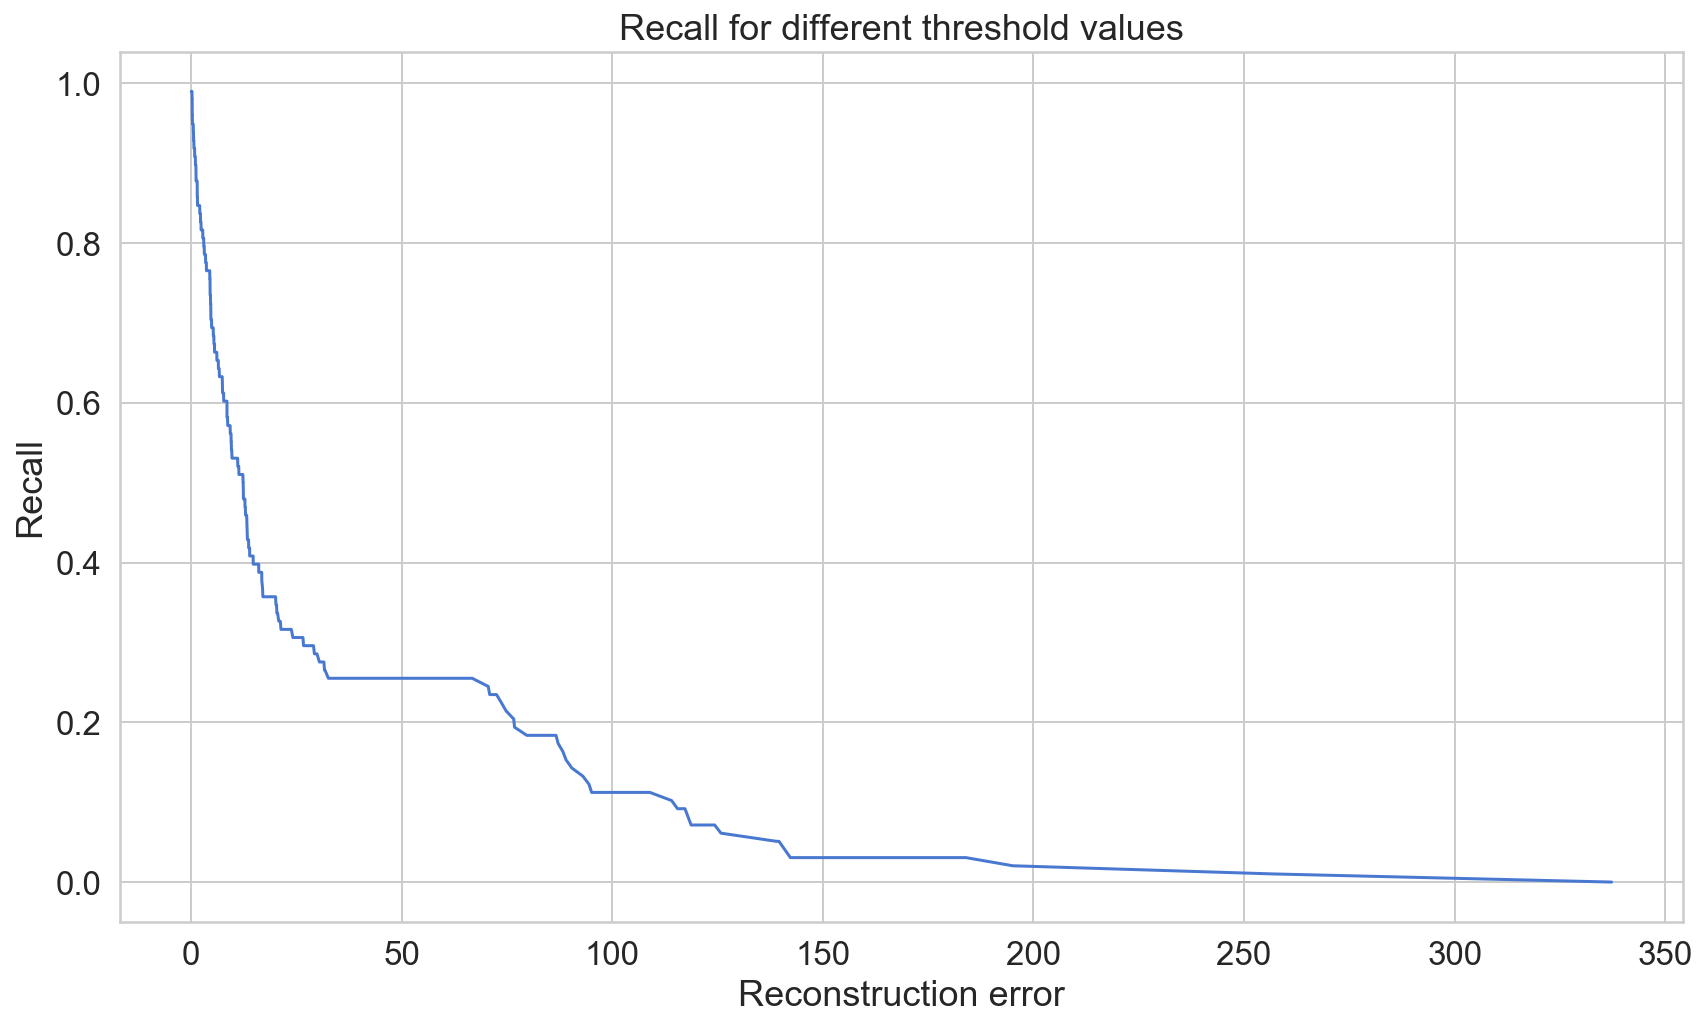

In [122]:
# Plot recall for different thresholds
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Our model doesn’t know how to predict new values. In order to predict whether or not a new transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions)! Let’s have a look at the confusion matrix:

In [123]:
# We fix a threshold
threshold = 2.2

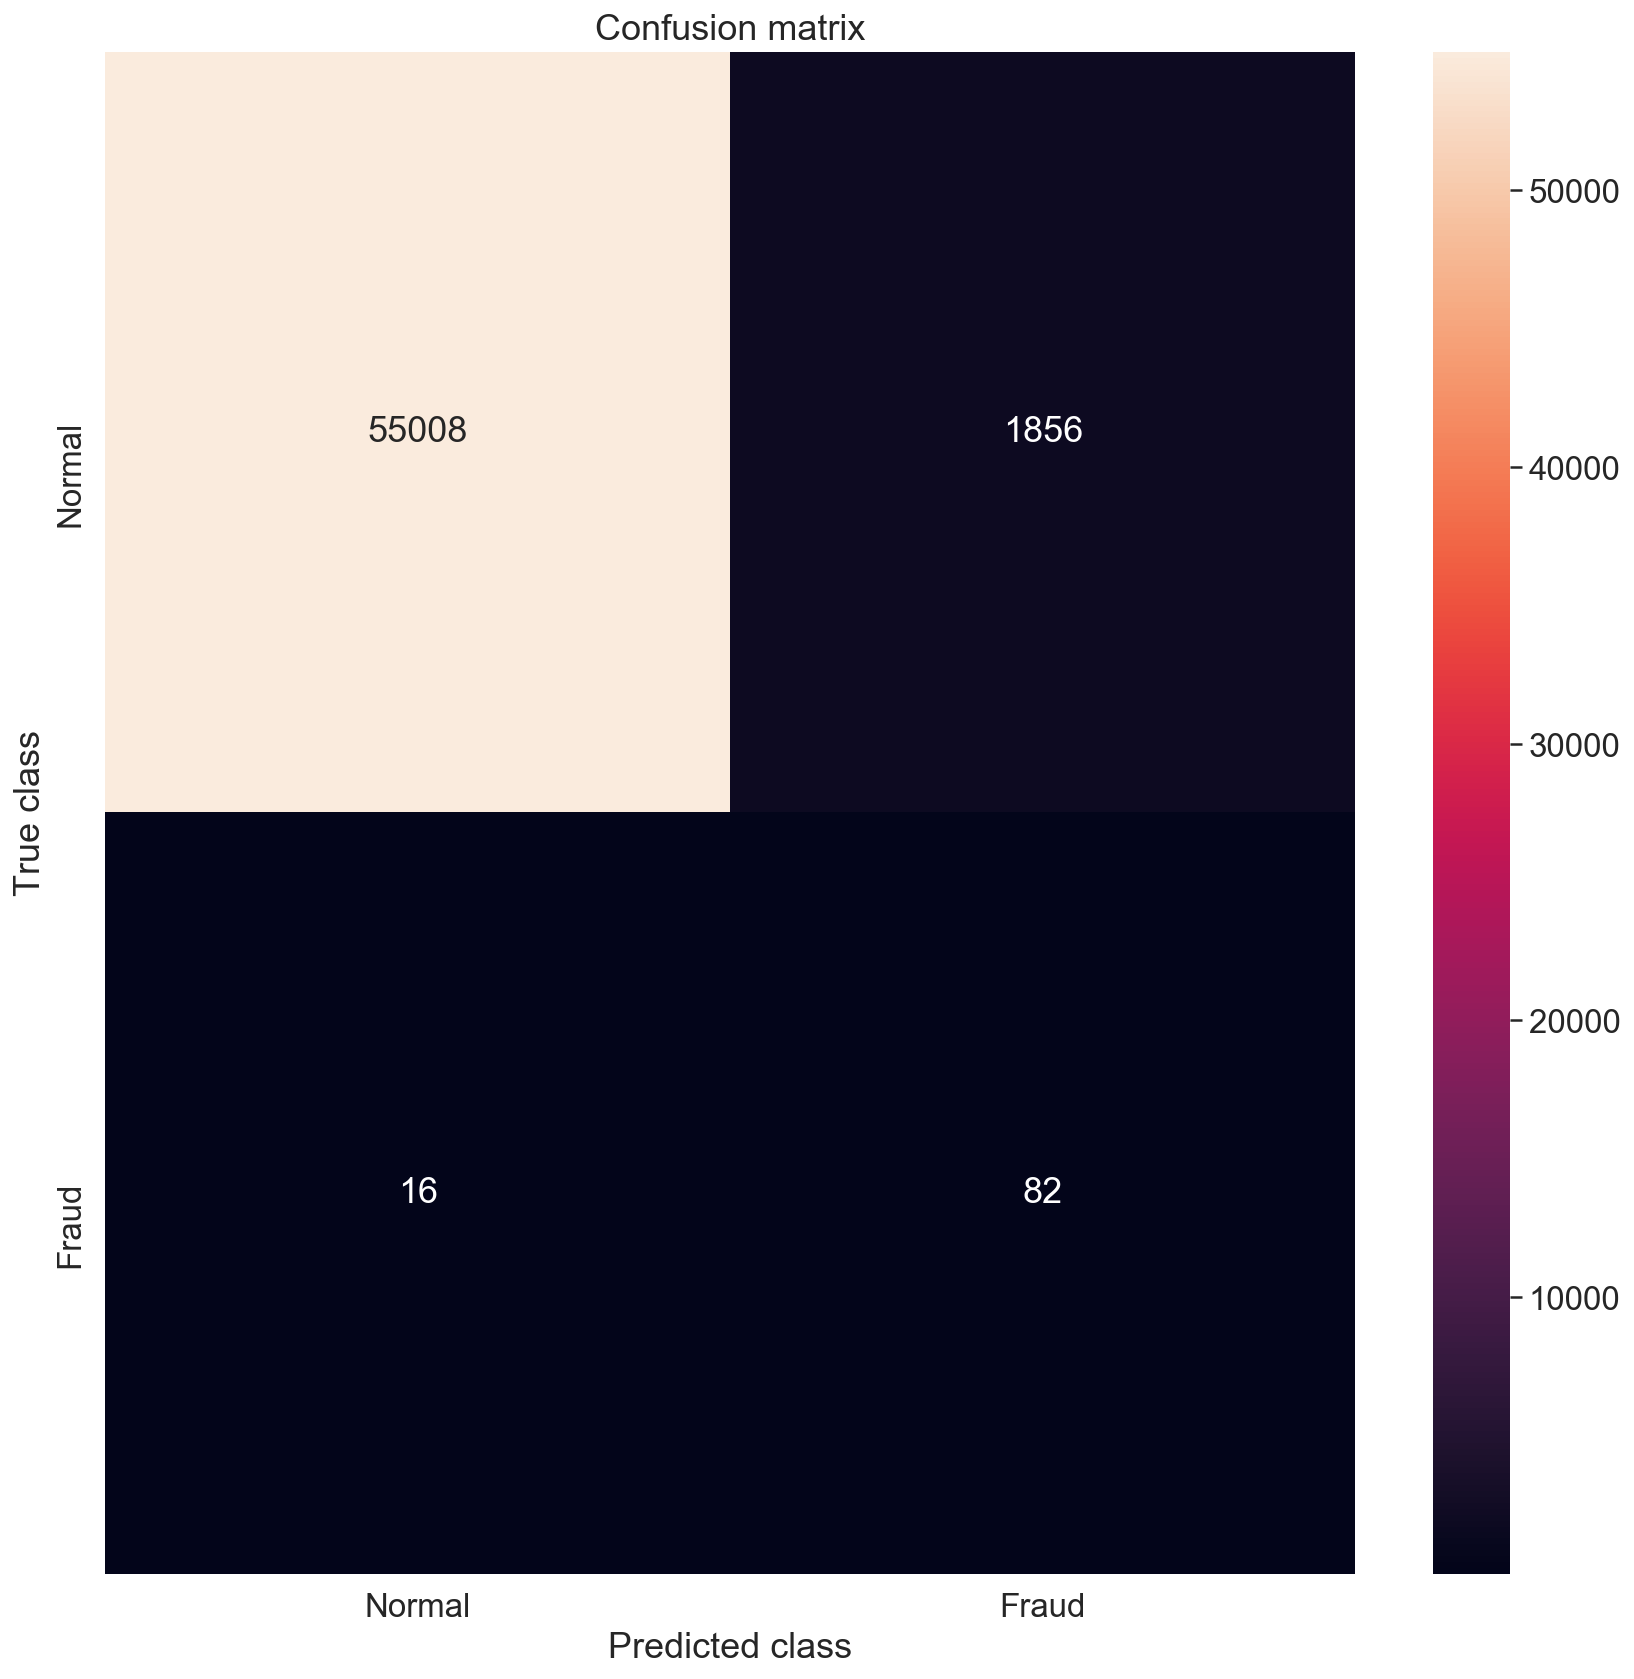

In [124]:
# Let us check the confusion matrix for the fixed threshold
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Alternative Model: RandomForests

Let us compare the results that we obtained with an alternative and (maybe) better model. We start again splitting the dataset between train and test set.

In [136]:
# Again, we split into training and testing sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train.shape

(227845, 23)

Let us create also a validation set:

In [137]:
# We use a subset of training for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=RANDOM_SEED)

We have a strongly imbalanced dataset, thus we can try to overcome this problem using an over-sampling technique.

In [138]:
# We balance the dataset using an oversampling technique
smote = SMOTE(random_state=RANDOM_SEED, ratio='auto', kind='regular')
X_train_ovsamp, y_train_ovsamp = smote.fit_sample(X_train, y_train)
X_train_ovsamp.shape

(409402, 23)

Now we can train an Random Forest classifier:

In [139]:
# Train the model
classifier = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model = classifier.fit(X_train_ovsamp, y_train_ovsamp)

# Evaluation
Again, we evaluate the model. First let us check if the model has overfitted the data printing the results on validation and testing sets.

In [140]:
# Print the results for validation and test sets
print('Validation Results')
print(rf_model.score(X_val, y_val))
print(recall_score(y_val, rf_model.predict(X_val)))
print('\nTest Results')
print(rf_model.score(X_test, y_test))
print(recall_score(y_test, rf_model.predict(X_test)))

Validation Results
0.999692780338
0.942857142857

Test Results
0.999508444226
0.836734693878


Plot the reconstruction error at each step:

In [141]:
# Check the reconstruction error 
mse = np.mean(np.power(np.array(y_test) - rf_model.predict(X_test), 2))
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,5.696200e+04,56962.000000
mean,4.915558e-04,0.001720
std,2.168423e-19,0.041443
min,4.915558e-04,0.000000
25%,4.915558e-04,0.000000
50%,4.915558e-04,0.000000
75%,4.915558e-04,0.000000
max,4.915558e-04,1.000000


Let us give a look at precision and recall:

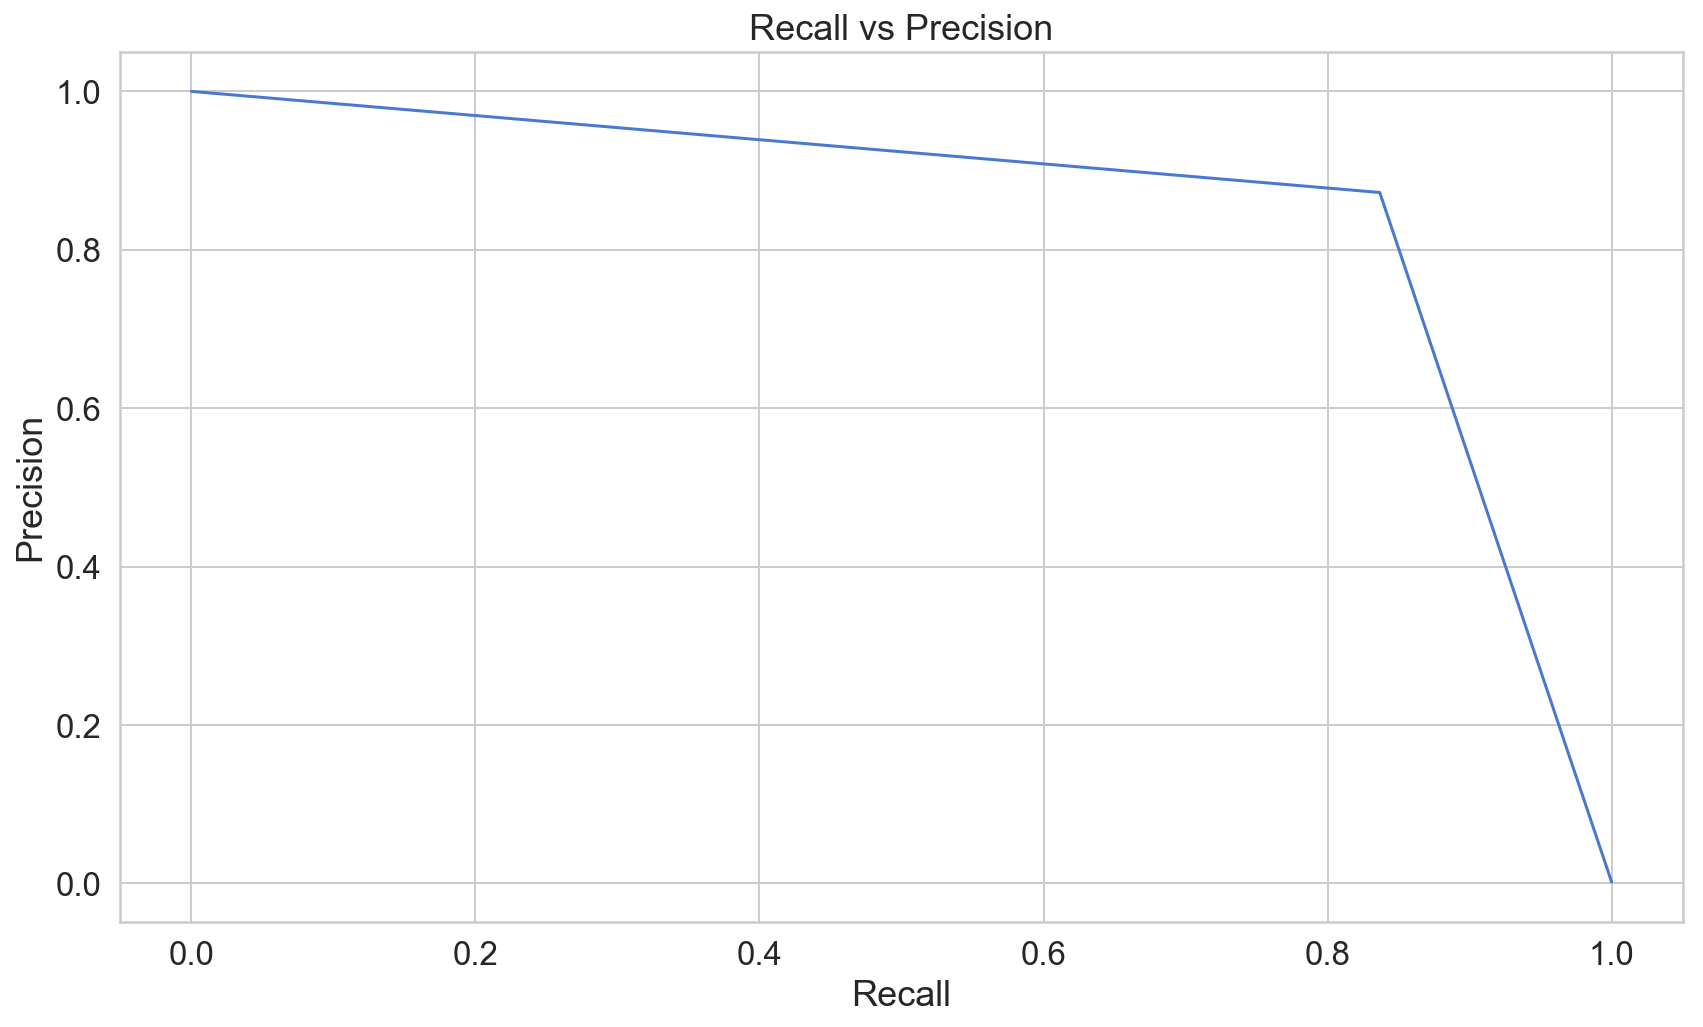

In [147]:
# Plot precision-recall curve
precision, recall, th = precision_recall_curve(y_test, rf_model.predict(X_test))
plt.figure(figsize=(14,8))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

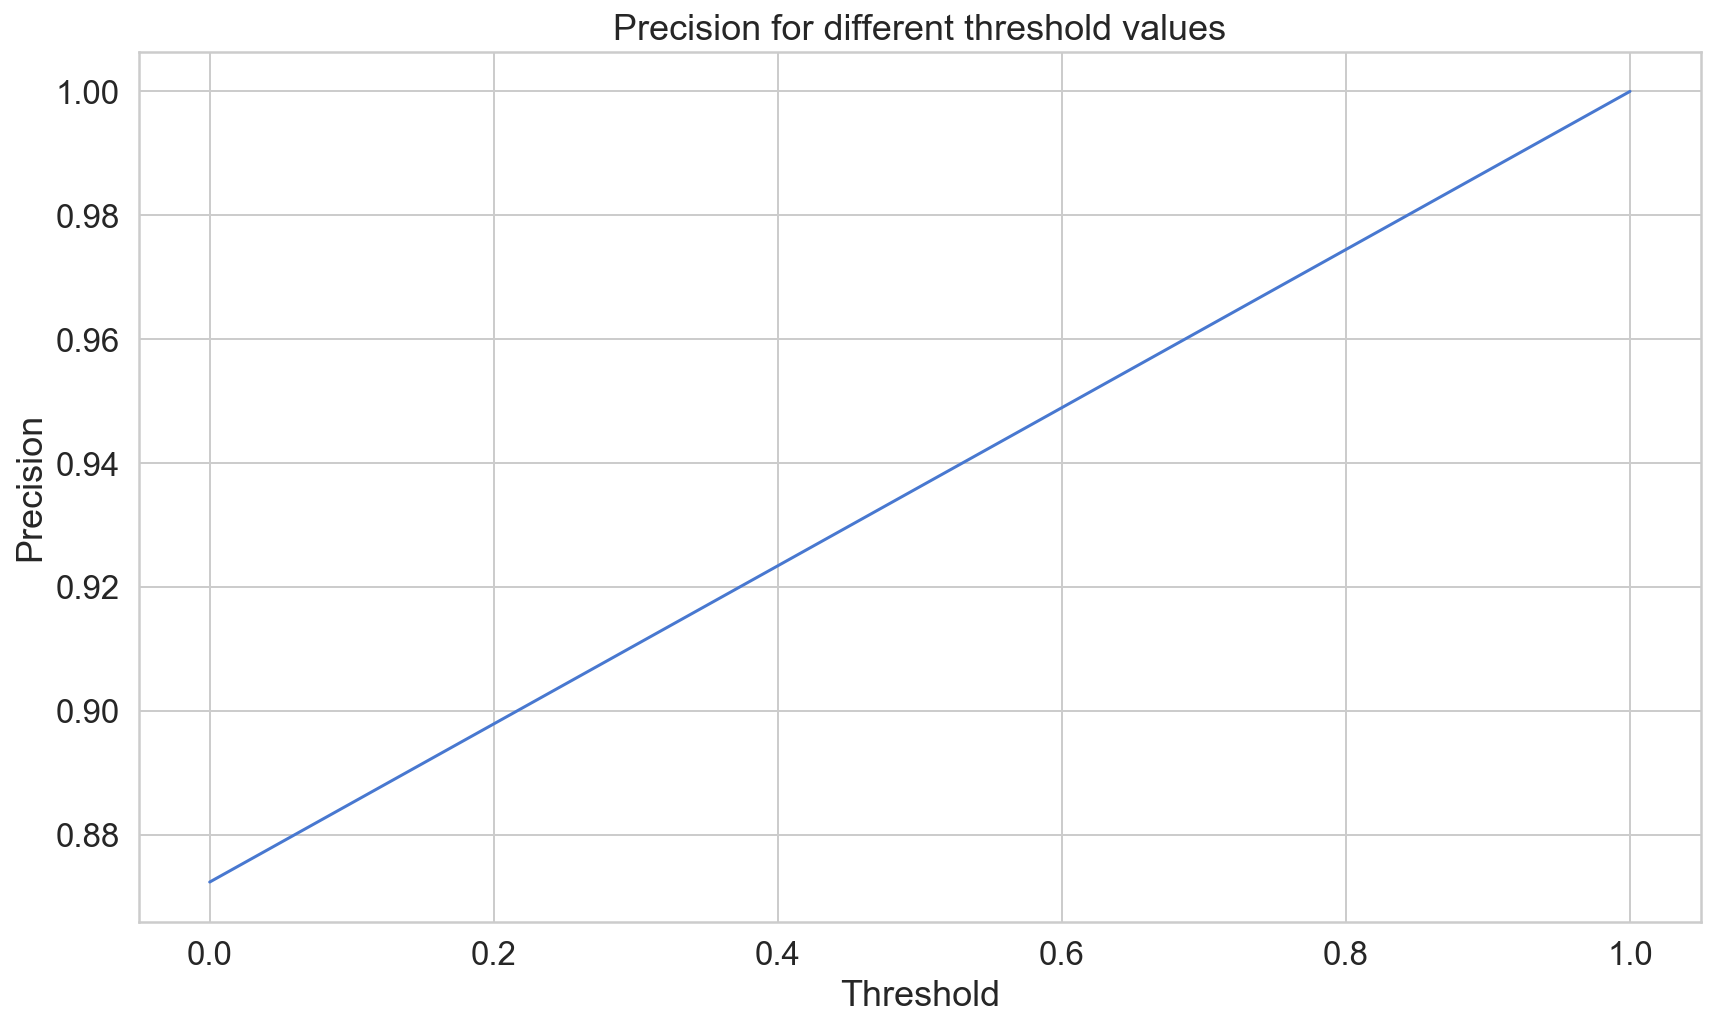

In [148]:
# Plot precision for different thresholds
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

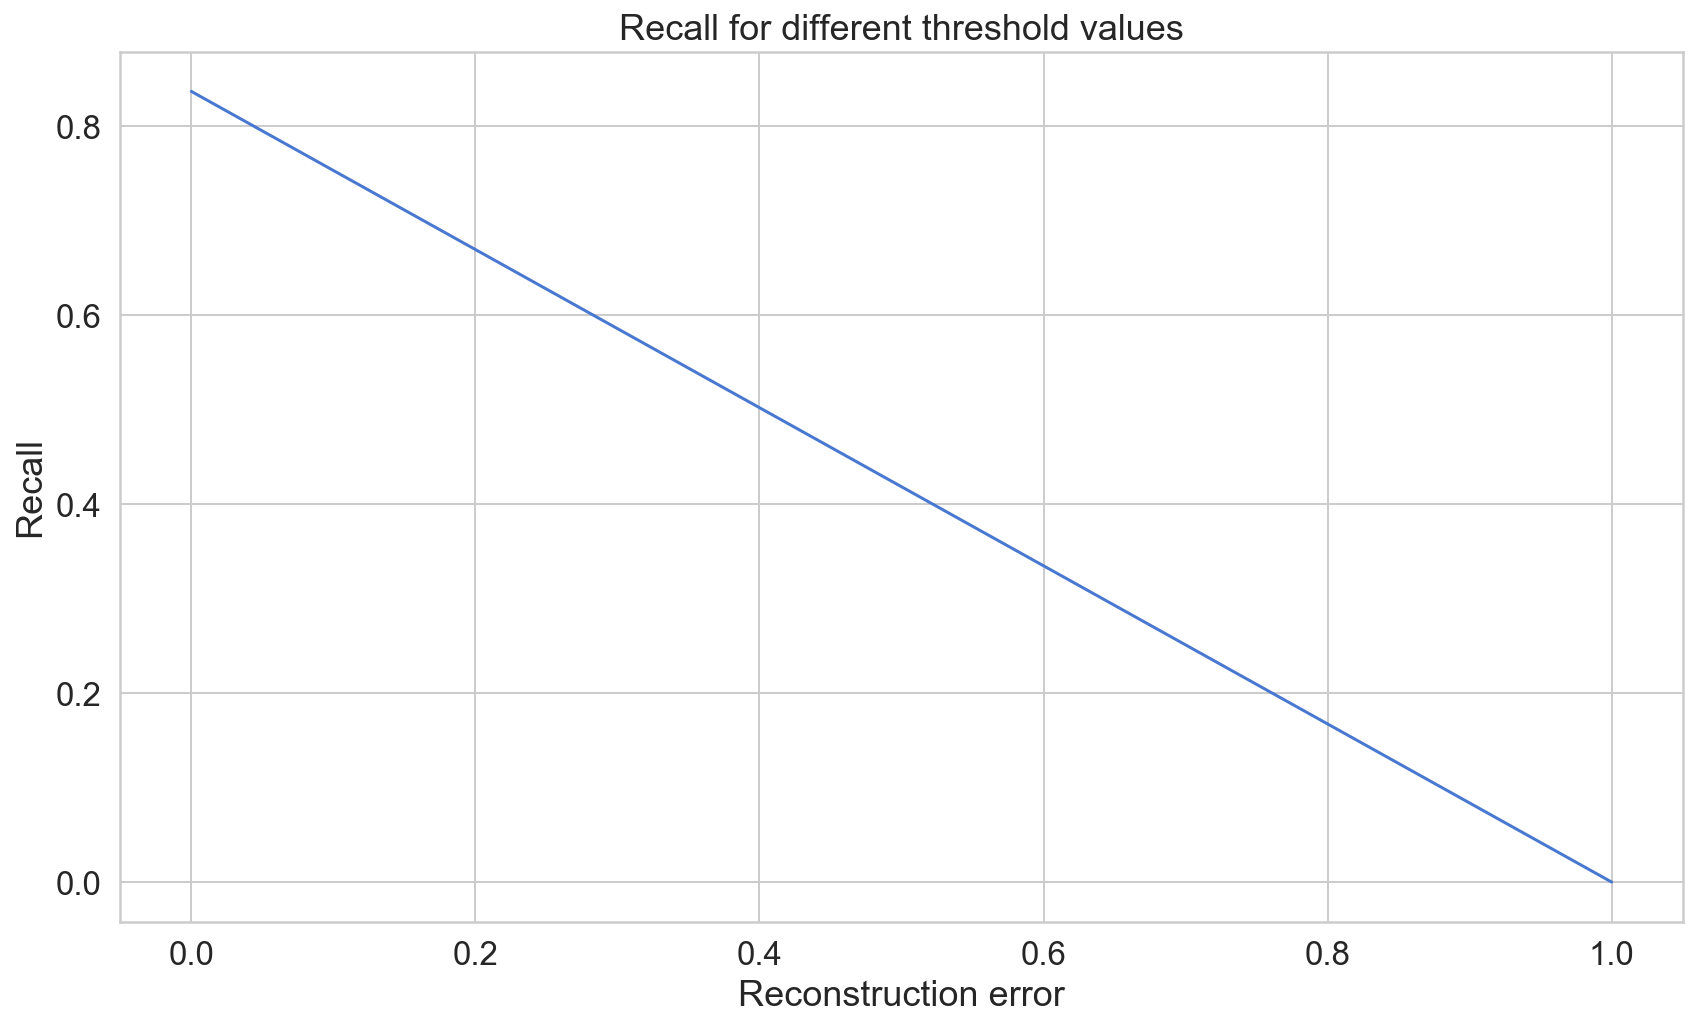

In [144]:
# Plot recall for different thresholds
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

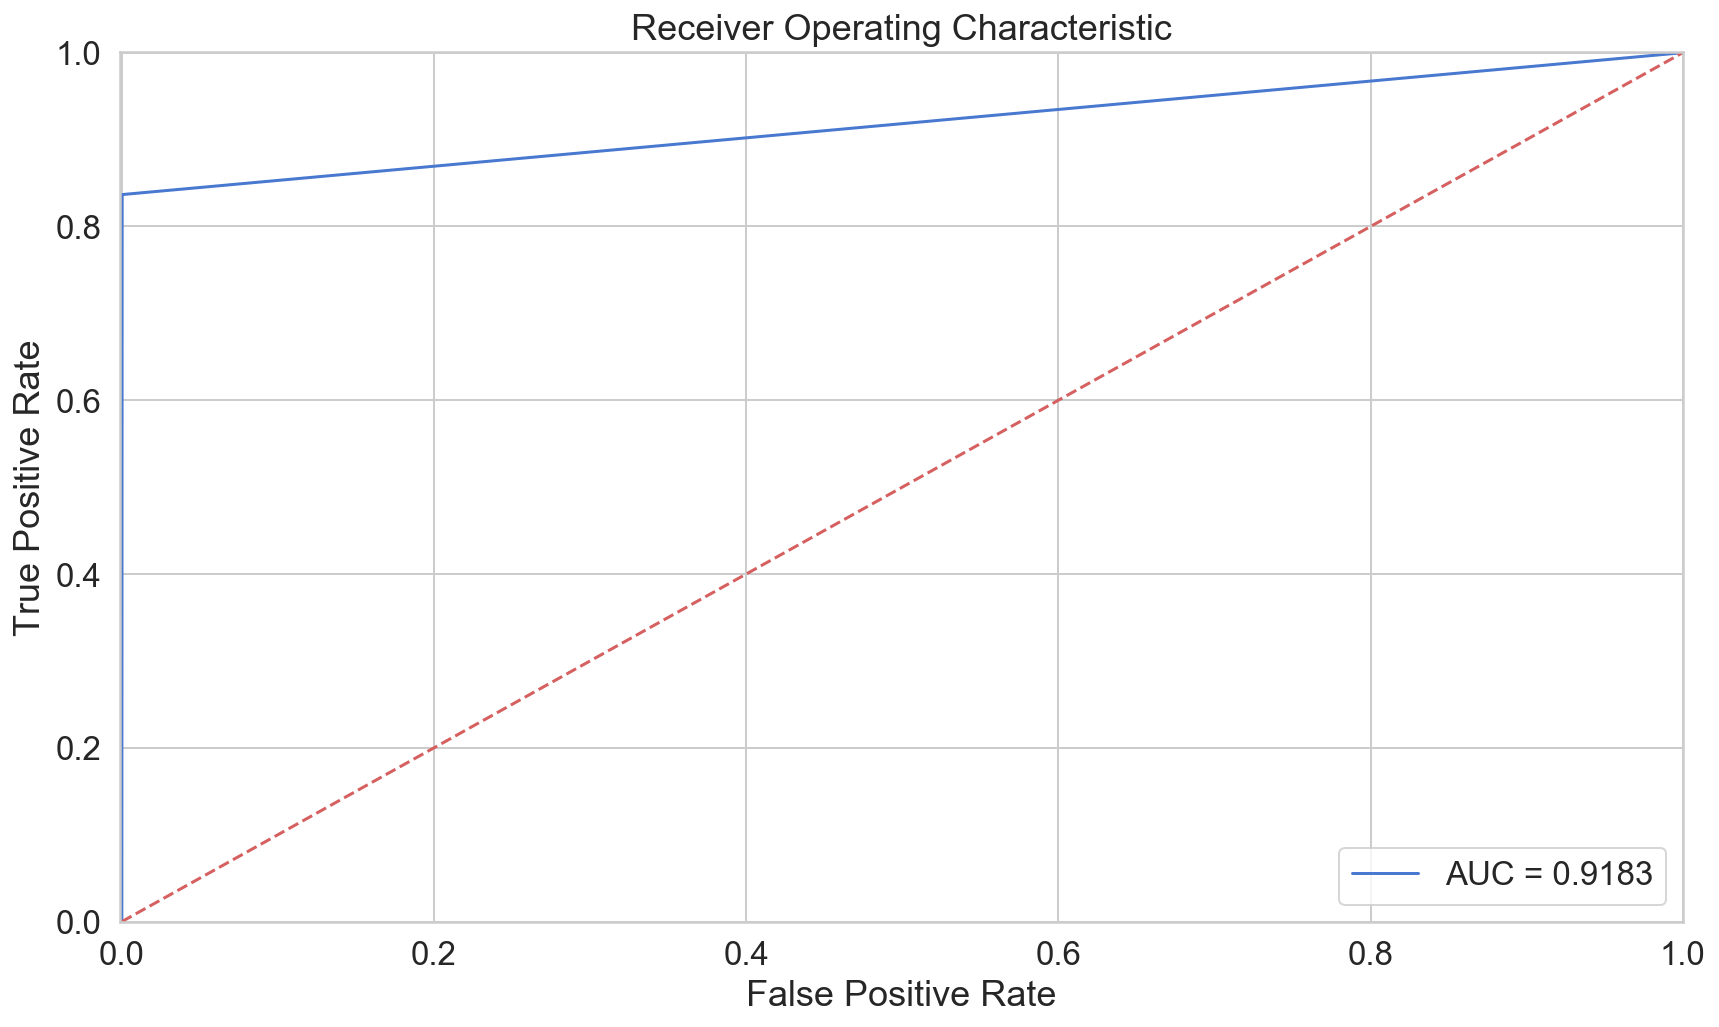

In [145]:
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict(X_test))
roc_auc = auc(fpr, tpr)

#Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Now we plot the confusion matrix to evaluate the results and compare the models.

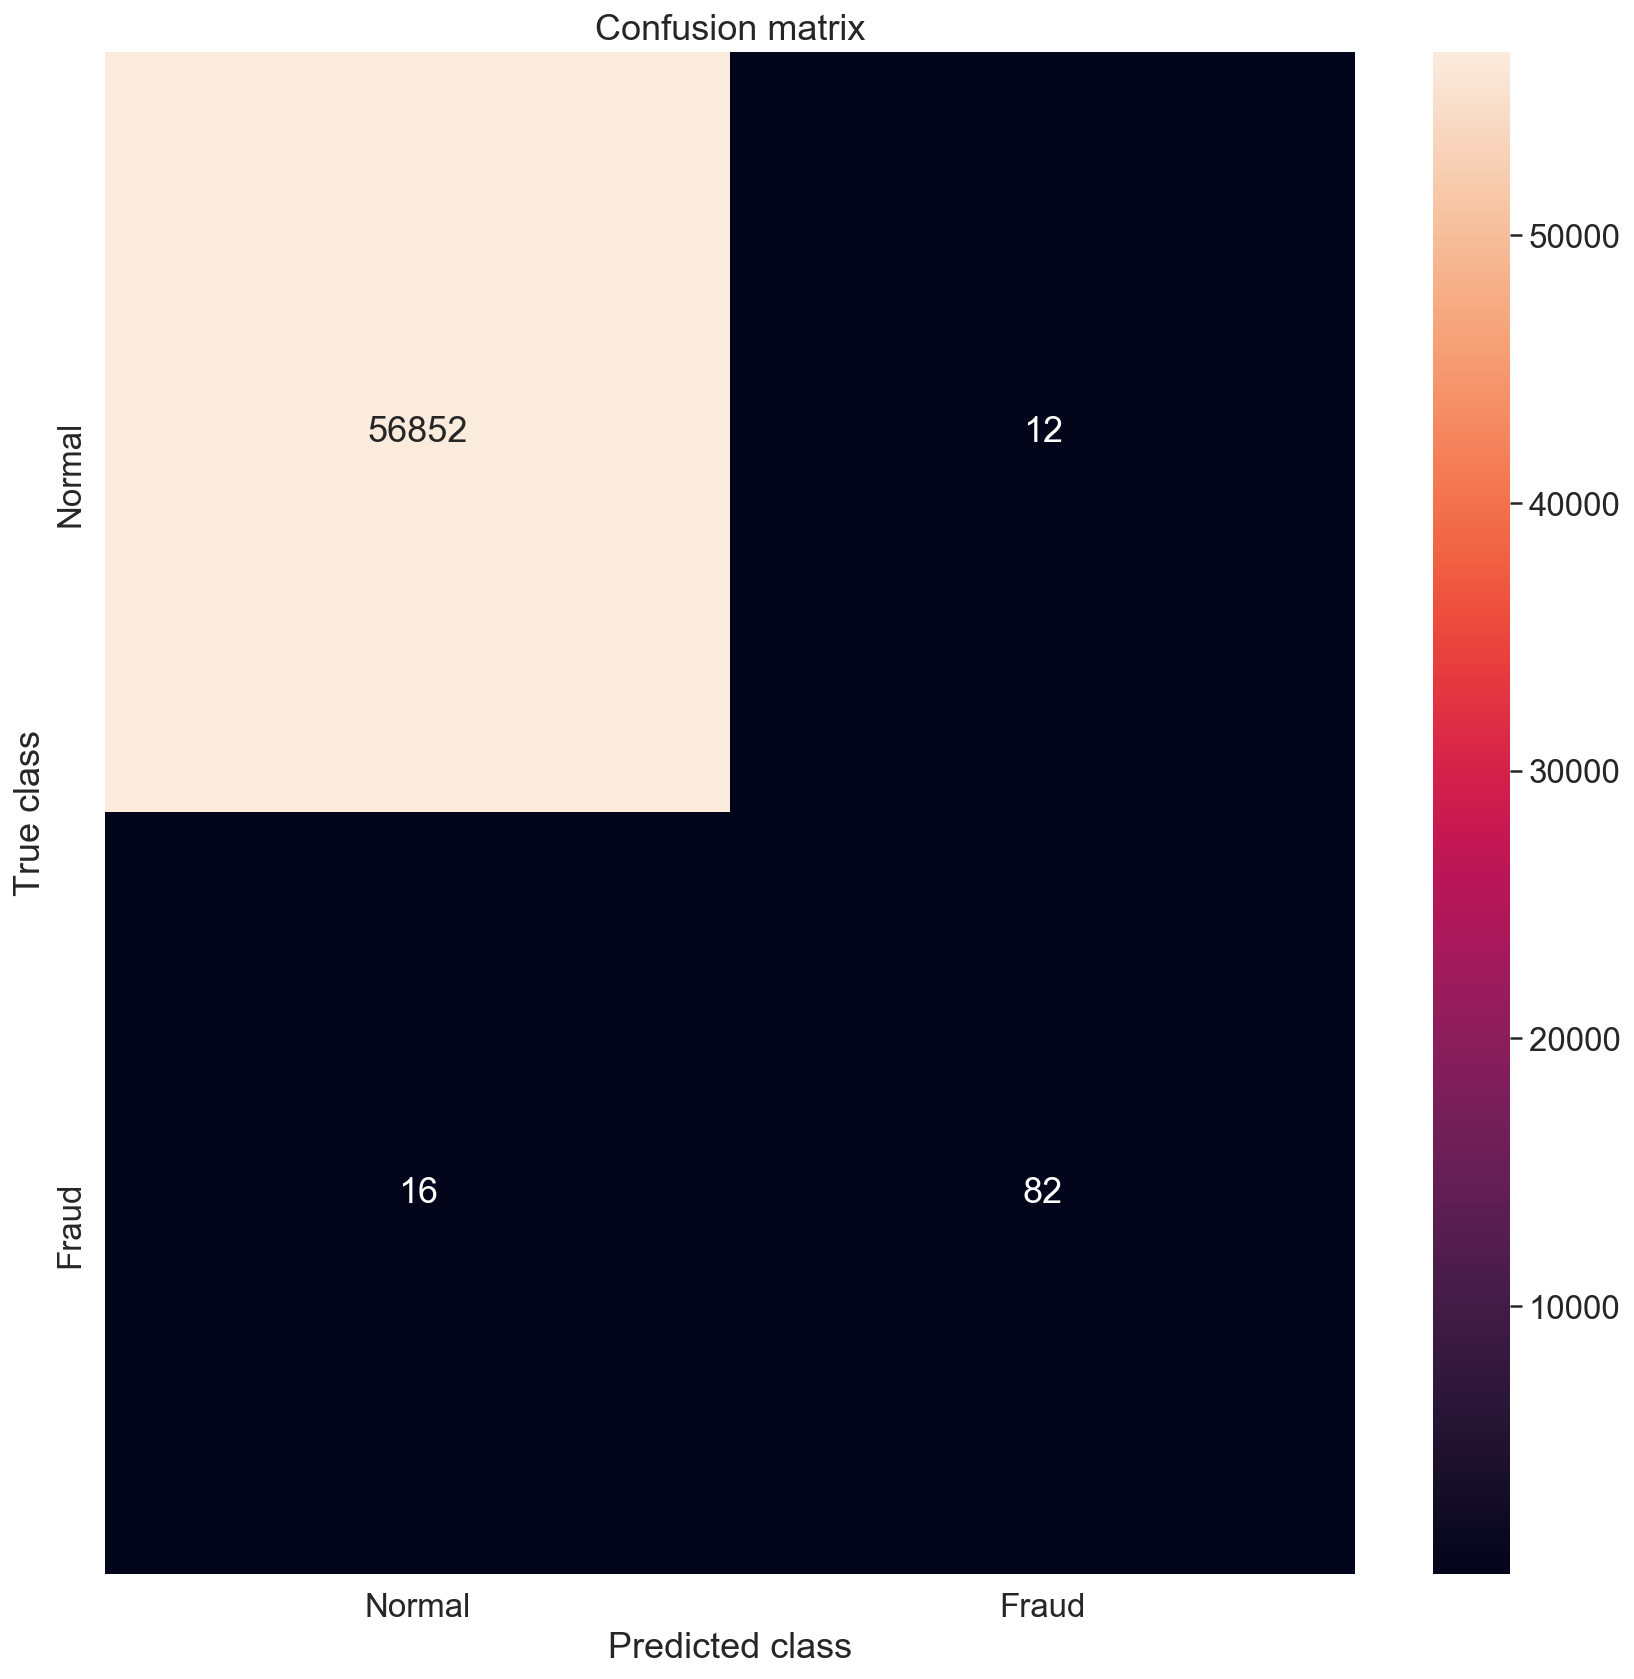

In [146]:
# Plot the confusion matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))
plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Conclusions

From the results above we can conclude that the Autoencoder does not perform as well as the Random Forest model. RandomForestClassifier is a lot faster, and has better values of precision and recall. The model has many less false posivies also. We can conclude that even if the autoencoder does its job, it is an optimal solution for this kind of problems.